In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML, Image

from abc import ABC, abstractmethod
import copy

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [2]:
# https://queirozf.com/entries/scikit-learn-examples-making-dummy-dataset
# https://towardsdatascience.com/https-medium-com-faizanahemad-generating-synthetic-classification-data-using-scikit-1590c1632922
X, y = make_classification(n_samples=400, n_features=10, n_informative=2, n_redundant=0,
                           n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=[0.5,0.5],
                           flip_y=0.01, class_sep=2, hypercube=True, shift=0.5, scale=1.0,
                           shuffle=True, random_state=45)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

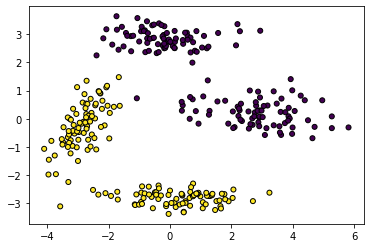

In [3]:
x_pca = PCA(n_components=2)
X_pca_train = x_pca.fit_transform(X_train)

x_pca = PCA(n_components=X_pca_train.shape[1])
X_pca_test = x_pca.fit_transform(X_test)
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

In [25]:
sum(x_pca.explained_variance_ratio_)

0.5758628383301243

In [ ]:
# No PCA is okay too
#   for visualization purpose, only restrict first 2 feature
x_train = X_train[:, :2] 
x_test = X_test[:, :2] 

plt.scatter(x_train[:, 0], x_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

***

In [4]:
class Activation(object):
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoidDerivative(self, x):
        return self.sigmoid(x) *  (1 - self.sigmoid(x))
    
    def softmax(self, z):
        z -= np.max(z)
        return np.exp(z) / np.sum(np.exp(z))

In [5]:
class HypotesisFunction(object):
    def __call__(self, x_val, theta):
        try:
            return x_val @ theta
        except Exception as ex:
            print(ex)
            print("x_val: {}".format(x_val))
            print("theta: {}".format(theta))

In [6]:
def to_onehot(y_val, num_classes=2):
    return (np.arange(num_classes + 1) == y_val[:, None]).astype(float)

Cross Entropy Loss

> $$ J(\theta )\quad \equiv \quad -㏑p({ C }_{ k }|\theta )\quad \equiv \quad { y }_{ k }(\theta )\quad =\quad \frac { 1 }{ m } \left( -\sum _{ i=1 }^{ m }{ \left[ y\quad .㏑{ h }_{ \theta  }\quad +\quad (1-y)\quad .㏑(1-{ h }_{ \theta  }) \right]  }  \right)   $$

Categorical Cross Entropy
> $$ { Loss }=-\sum _{ i=1 }^{ { outputsize } } y_{ i }\cdot { log }\; { \hat { y }  }_{ i } $$

In [7]:
class Loss(object):
    # Binary Cross-Entropy
    def binaryCrossEntropy(self, y_real, y_pred, eps=1e-8, **kwargs):
        h_p = np.log(y_pred + eps)
        d_pq = np.log(1 - y_pred + eps)
        return 1 / len(y_real) * -np.sum(
                            y_real * h_p + (1-y_real) * d_pq
                        )

    # Categorical Cross-Entropy
    def categoricalCrossEntropy(self, y_real, y_pred, **kwargs):
        # ini gak bisa pake one-hot encoding
        # sistem yg dibuat secara default akan membuat jika memilih is_maxent=Truen
        #   otomatis akan membuat y_real dalam bentuk one-hot encoding, karena itu
        #   perlu convert kembali ke format integer-label-encoding 
        y_real = np.argmax(y_real, axis=1)
        m = kwargs.get('m', 1)
        return np.sum(- np.log(y_pred[np.arange(m), y_real]))
    
    def categoricalCrossEntropy2(self, y_real, y_pred, epsilon=1e-12, **kwargs):
        # https://stackoverflow.com/questions/47377222/what-is-the-problem-with-my-implementation-of-the-cross-entropy-function
        """
        Computes cross entropy between targets (encoded as one-hot vectors)
        and predictions. 
        Input: predictions (N, k) ndarray
               targets (N, k) ndarray        
        Returns: scalar
        """
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        ce = -np.sum(y_real*np.log(y_pred + 1e-9))/N
        return ce

***
## Solution and Optimization
#### Gradient Descent

In [8]:
class _BaseModel(object):
    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator"""
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, 'deprecated_original', cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = inspect.signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [p for p in init_signature.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD]
        for p in parameters:
            if p.kind == p.VAR_POSITIONAL:
                raise RuntimeError(" estimators should always "
                                   "specify their parameters in the signature"
                                   " of their __init__ (no varargs)."
                                   " %s with constructor %s doesn't "
                                   " follow this convention."
                                   % (cls, init_signature))
        # Extract and sort argument names excluding 'self'
        return sorted([p.name for p in parameters])
    
    def get_params(self, deep=True):
       
        out = dict()
        for key in self._get_param_names():
            try:
                value = getattr(self, key)
            except AttributeError:
                value = None
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out
    
    def set_params(self, **params):

        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition('__')
            
            if key not in valid_params: # kalo mau nambah yg diluar ini kyknya gak perlu di else
                raise ValueError('Invalid parameter %s for estimator %s. '
                                 'Check the list of available parameters '
                                 'with `estimator.get_params().keys()`.' %
                                 (key, self))

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self

class GradientDescent(ABC, Activation, _BaseModel):
    def __init__(self, lr=0.01, epoch=100, use_regularized=False, theta=None,
                 eps=1e-8, batch_size=None, shuffle=False, clipping=False, **kwargs):
        
        assert lr!=0, 'Learning rate can not be null'
        
        self.lr = lr
        self.epoch = epoch
        self.use_regularized = use_regularized
        self.theta = theta
        self.eps = eps # Smoothing to avoid division by zero
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.clipping = clipping
        self.kwargs = kwargs

    @abstractmethod
    def gradient(self):
        return

    def initWeight(self, shape, mu=0, sigma=0.1):
        return np.random.normal(mu, sigma, shape)
    
    def transform(self, x_val, theta, hypo_function):
        return hypo_function(x_val, theta)
    
    def activation(self, link_func, prediction):
        return link_func(prediction)
    
    @abstractmethod
    def fit(self, x_val, y_val, loss_func, hypo_func, 
            theta, appx_theta=None, is_maxent=False, **kwargs):
        """Fit model."""
        lambd = self.kwargs.get('lambd', 1)
        loss_type = self.kwargs.get('loss_type', 'l2')
        
        if is_maxent:
            link_func = self.softmax
        else:
            link_func = self.sigmoid

        # make prediction
        if appx_theta is None:

            predictions = self.activation(link_func , self.transform(x_val, theta, hypo_func))
            
            # calculate loss
            step_loss = self.stepLost(loss_func, y_pred=predictions,
                                      y_real=y_val, theta=theta,
                                      regularized=self.use_regularized,
                                      lambd=lambd, loss_type=loss_type,
                                      is_sgd=kwargs.get('is_sgd', False),
                                      m=kwargs.get('m', 1)
                                    )
        else:
            # for Nesterov
            predictions = self.applyActivation(link_func , self.transform(x_val, theta, hypo_func))

            # calculate loss
            step_loss = self.stepLost(loss_func, y_pred=predictions,
                                      y_real=y_val, theta=appx_theta,
                                      regularized=self.use_regularized,
                                      lambd=lambd, loss_type=loss_type,
                                      is_sgd=kwargs.get('is_sgd', False),
                                      m=kwargs.get('m', 1)
                                     )

        # calculate gradient
        gradient = self.gradient(m=kwargs.get('m', 1),
                                 x_val=x_val,
                                 prediction=predictions,
                                 y_val=y_val)
        
        if self.use_regularized:
            if appx_theta is None:
                reg_term = (lambd/2) * theta
            else:
                reg_term = (lambd/2) * appx_theta
        else:
            reg_term = 0

        return step_loss, predictions, gradient, reg_term
    
    @abstractmethod
    def step(self, gradient, reg_term=0):
        """implement on child"""
    
    @abstractmethod
    def stepLost(self,**kwargs):
        """calculate gradient step loss."""
        return

In [9]:
class BatchGradientDescent(GradientDescent):
    def gradient(self, m=None, x_val=None, prediction=None, y_val=None):
        gradient = None
        try:
            gradient = (1/m) * (x_val.T @ (prediction - y_val))
            if self.clipping and np.linalg.norm(gradient) > 1:
                gradient = gradient/np.linalg.norm(gradient)
        except Exception as ex:
            print("len(self.classes): {}".format(len(self.classes)))
            print()
        
        return gradient
    
    def unisonShuffledCopies(self, a, b):
        # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    def stepLost(self, func, **kwargs):
        return func(**kwargs)
    
    def checkConvergence(self, theta_copy, theta, epoch, rtol=1e-05, atol=1e-08):
        if np.allclose(theta_copy, theta, rtol=rtol, atol=atol, equal_nan=True):
            # if almost equal then we can stated it as converge
            print("Convergence achieved on epoch: {}".format(epoch))
            self.is_convergence = True

    def gradientOptimizer(self, gradient, reg_term, gamma, epoch_t):
        theta_copy = copy.copy(self.theta)

        if self.kwargs.get('use_momentum', False):
            # standard momentum strategy
            self.velocity = gamma * self.velocity + self.lr * (gradient + reg_term)
            self.theta -= self.velocity
        elif self.kwargs.get('use_rmsprop', False):
            # accumulate gradient
            self.velocity = gamma * self.velocity + ((1 - gamma) * ((gradient + reg_term)**2))
            
            # update parameter
            self.theta -= (self.lr / (np.sqrt(self.velocity) + self.eps)) * gradient
        elif self.kwargs.get('use_adam', False):
            epoch_t+=1
            beta1 = .9
            beta2 = .999
            
            # kalau jumlah parameter_theta > 1, M dan R menyesuaikan
            self.M = beta1 * self.M + (1. - beta1) * gradient #updates the moving averages of the gradient
            self.R = beta2 * self.R + (1. - beta2) * gradient**2 #updates the moving averages of the squared gradient

            m_k_hat = self.M / (1. - beta1**(epoch_t)) #calculates the bias-corrected estimates
            r_k_hat = self.R / (1. - beta2**(epoch_t)) #calculates the bias-corrected estimates
            
            self.theta -= self.lr * m_k_hat / (np.sqrt(r_k_hat) + self.eps)
            
        self.checkConvergence(theta_copy, self.theta, epoch_t)

    def nextBatch(self, x_val, y_val):
        # loop over our dataset `X` in mini-batches of size `batchSize`
        for i in np.arange(0, x_val.shape[0], self.batch_size):
            # yield a tuple of the current batched data and labels
            yield (x_val[i:i + self.batch_size], y_val[i:i + self.batch_size])

    def fitOvr(self, x_val, y_val, loss_func, hypo_func, velocity=None, m=2, n=3):
        appx_theta=None

        for c in self.classes:
            print("c: {}".format(c))
            self.theta = self.initWeight(n,
                                         mu=self.kwargs.get('mu', 0),
                                         sigma=self.kwargs.get('sigma', 0.1),
                                        )
            
            binary_y = np.where(y_val == c, 1, 0)
            self.is_convergence = False
            self.fitLoop(x_val, binary_y, loss_func, hypo_func, m=m)
           
            self.theta_classes.append(copy.copy(self.theta))
   
    def fitLoop(self, x_val, y_val, loss_func, hypo_func, m=2, is_maxent=False):
        for step in range(self.epoch):
            if not self.is_convergence:
                batchstep_loss = []
                if self.shuffle:
                    x_val, y_val = self.unisonShuffledCopies(x_val, y_val)
                for (batch_x, batch_y) in self.nextBatch(x_val, y_val):
                    step_loss, predictions, \
                        gradient, reg_term = super(BatchGradientDescent, self).fit(batch_x,
                                                                                   batch_y,
                                                                                   loss_func,
                                                                                   hypo_func,
                                                                                   #self.sigmoid,
                                                                                   self.theta,
                                                                                   is_maxent=is_maxent,
                                                                                   m=m
                                                                                  )

                    if self.kwargs.get('use_momentum', False) or self.kwargs.get('use_rmsprop', False) \
                        or self.kwargs.get('use_adam', False):
                        self.gradientOptimizer(gradient, reg_term,
                                               gamma=self.kwargs.get('gamma', 0.9),
                                               epoch_t=step
                                              )
                    else:
                        self.step(gradient, reg_term=reg_term, epoch_t=step)


                    batchstep_loss.append(step_loss)
                self.gradient_hist.append(gradient)

                self.loss_hist.append(np.average(batchstep_loss))

    def fit(self, x_val, y_val, loss_func, hypo_func, is_maxent=False):
        m, n = x_val.shape

        if self.batch_size is not None:
            m = self.batch_size

        if self.theta is None:
            self.theta = self.initWeight(n)

        self.is_convergence = False
        self.velocity = None
        
        if self.kwargs.get('use_adam', False):
            # karena Logistic Regression hanya memiliki 1 weight
            #  tidak seperti MLP yang memiliki hidden layer karena itu
            #    pasti memiliki beberapa parameter_theta/weight
            self.M = np.zeros_like(self.theta) # gradient / self.theta yak?
            self.R = np.zeros_like(self.theta)
            
            self.kwargs.pop('use_momentum', None)
            self.kwargs.pop('use_rmsprop', None)

        if self.kwargs.get('use_momentum', False) or self.kwargs.get('use_rmsprop', False):
            self.velocity = np.zeros_like(n)
            
        if self.kwargs.get('use_momentum', False) and self.kwargs.get('use_rmsprop', False):
            # just allow one
            raise ValueError('Choose momentum or rmsprop, can not both!')
            
                
        self.init_w = copy.copy(self.theta)
        self.loss_hist = []
        self.gradient_hist = []
        
        self.classes = np.unique(y_val)
        
        if is_maxent:
            y_val = to_onehot(y_val, num_classes=max(self.classes))
        
        if len(self.classes) > 2 and is_maxent is False:
            self.theta_classes = []
            self.fitOvr(x_val, y_val, loss_func, hypo_func, m=m, n=n)
        else:
            self.fitLoop(x_val, y_val, loss_func, hypo_func, m=m)
        return self
        
    def step(self, gradient, reg_term=0, epoch_t=1):
        # create copy of theta for convergence check
        theta_copy = copy.copy(self.theta)
        
        # update weight
        self.theta -= self.lr * (gradient + reg_term)
        
        self.checkConvergence(theta_copy, self.theta, epoch_t)

    def predictProba(self, x_val, hypo_function, ex_fit_intercept=False):
        if ex_fit_intercept:
            intercept = np.ones((x_val.shape[0], 1))
            x_val = np.concatenate((intercept, x_val), axis=1)

        return self.sigmoid(hypo_function(x_val, self.theta))
    
    def predict(self, x_val, hypo_function):
        return self.predictProba(x_val, hypo_function).round()
    
    def predictMaxent(self, x_val, hypo_function):
        return self.softmax(hypo_function(x_val, self.theta)).argmax(axis=1)
    
    def predictMulti(self, x_val, hypo_function):
        proc_activation = lambda xi, theta: self.activation(self.sigmoid ,
                                                            self.transform(xi,
                                                            theta,
                                                            hypo_function))
        preds = [np.argmax(
                    [proc_activation(xi, theta) for theta in self.theta_classes]
                ) for xi in x_val]
        return [self.classes[p] for p in preds]

***

In [10]:
m, n = X_pca_train.shape # x_train.shape #
mt, nt = X_pca_test.shape # x_test.shape # 

bias_value = 0
if bias_value == 1:
    X_ = np.hstack((np.full((m, 1), bias_value), X_pca_train))
    print(X_[:5, :])

    _X_ = np.hstack((np.full((mt, 1), bias_value), X_pca_test))
    print(_X_[:5, :])
else:
    X_ = X_pca_train
    _X_ = X_pca_test
    
    print(X_[:5, :])
    print(_X_[:5, :])

[[ 0.98996598 -2.75071246]
 [-0.57683342  3.31146206]
 [-3.32219157 -0.65796781]
 [-2.72314795  0.16389857]
 [ 3.98122888  1.0062705 ]]
[[-0.08712711 -1.98894263]
 [-2.60007915 -3.168129  ]
 [ 0.47477     2.76421518]
 [-2.62094654 -1.35828633]
 [-2.41695381  0.22171629]]


In [11]:
h = HypotesisFunction()
J = Loss()
A = Activation()

In [40]:
is_maxent_classifier = False

batch_sz = 1 # X_.shape[0] #
clipping_ = False
epoch_ = 100
alpha = 0.001
gamma_ = 0.9
shuffle_ = True
regularized_ = False
sigma_ = 0.2 # jadi std-dev buat generate weight

if is_maxent_classifier:
    class_cnt = len(np.unique(y_train)) # jumlah kelas
    feature_cnt = X_.shape[1]
    theta_ = np.random.random((feature_cnt, class_cnt))
else:
    theta_ = None

batchgd = BatchGradientDescent(lr=alpha, epoch=epoch_,
                                #use_momentum=True,
                                #use_rmsprop=True,
                                use_adam=True,
                                gamma_=gamma_,
                                shuffle=shuffle_,
                                use_regularized=regularized_,
                                batch_size= batch_sz, 
                                sigma=sigma_,
                                clipping = clipping_,
                                
                                # aktifkan theta untuk maxent classifier
                                theta = theta_
                              )


if is_maxent_classifier:
    gd = batchgd.fit(X_, y_train, J.categoricalCrossEntropy2, h, is_maxent=True)
else:
    gd = batchgd.fit(X_, y_train, J.binaryCrossEntropy, h, is_maxent=False)


Convergence achieved on epoch: 71
Convergence achieved on epoch: 71
Convergence achieved on epoch: 71
Convergence achieved on epoch: 71
Convergence achieved on epoch: 71
Convergence achieved on epoch: 71
Convergence achieved on epoch: 71


In [41]:
#preds = gd.predictMulti(_X_, h) # untuk multi-class pake ini ovr
preds = gd.predict(_X_, h) # untuk binary class
#preds = gd.predictMaxent(_X_, h) # untuk multi-class dengan maximum entropy classifier

# cek akurasi
print("Acc: {:2f}".format((preds == y_test).mean()))
#(preds == y_test).mean()

Acc: 0.537500


In [22]:
batchgd.velocity

array([ 0.00070094, -0.00035352])

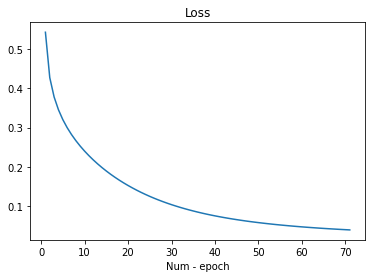

In [42]:
plt.plot(np.arange(1, len(gd.loss_hist)+1, 1), gd.loss_hist, label="GD batch_size: {}".format(batch_sz))
plt.title('Loss')
plt.xlabel('Num - epoch')
plt.show()

***

* yang perlu diperhatikan pada contour plot untuk mempelajari GD, adalah contour/surface yang digunakan adalah surface dari error. Kenapa?
* Seperti yang kita tau, kalau Gradient Descent menjadi cara untuk meminimalisir error yang ada dengan melakukan optimasi nilai parameter_theta/weight

In [18]:
#Setup of meshgrid of theta values
T1 = np.linspace(-5, 5, 160)
T2 =  np.linspace(-5, 5, 160)
M, B = np.meshgrid(T1, T2)

* Untuk maxent classifier harus dirubah dahulu binaryCrossEntropynya

<a list of 24 text.Text objects>

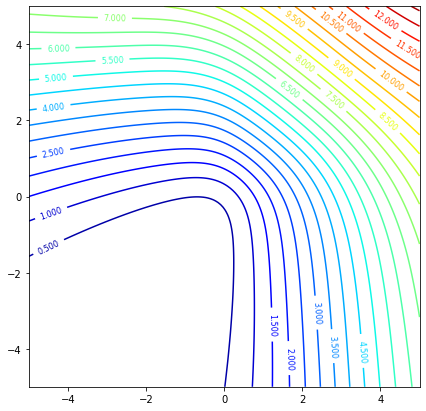

In [43]:
from numpy import inf
zs = []

for t0, t1 in zip(np.ravel(M), np.ravel(B)):
    if X_.shape[1] > 2:
        arr_theta = np.hstack((np.random.normal(abs(t0), abs(t0), X_.shape[1]-2), np.array([t0, t1])))
    else:
        arr_theta = np.array([t0, t1])
    # not for maxent
    l = J.binaryCrossEntropy(y_train, A.sigmoid(h(X_, arr_theta)))
    zs.append(l)

zs = np.array(zs)
Z = zs.reshape(M.shape)

#Plot the contour
fig1, ax1 = plt.subplots(figsize = (7,7))


contours = ax1.contour(M, B, Z, 30, cmap = 'jet')
plt.clabel(contours, inline=True, fontsize=8)

In [44]:
# usahakan < 1000, lebih dari itu suka lama bener
len(gd.gradient_hist)

71

In [ ]:
theta_i = gd.gradient_hist[-1]

# Create animation
line, = ax1.plot([], [], 'r', label = 'Gradient descent', lw = 1.5)
point, = ax1.plot([], [], '*', color = 'red', markersize = 10)
value_display = ax1.text(0.02, 0.02, '', transform=ax1.transAxes)
value_title = ax1.set_title('Loss type:{}, degree:{}, lr:{}'.format('L1',2, 0.01))

def init_1():
    line.set_data([t[0] for t in gd.gradient_hist], [t[1] for t in gd.gradient_hist])
    point.set_data([theta_i[0]], [theta_i[1]])

    return line, point, value_display

def animate_1(i):
    # Animate line
    line.set_data(np.array(gd.gradient_hist)[:,:1][:i], np.array(gd.gradient_hist)[:,1:2][:i])
    
    # Animate points
    point.set_data(np.array(gd.gradient_hist)[:,:1][i], np.array(gd.gradient_hist)[:,1:2][i])

    # Animate value display
    try:
        value_display.set_text('loss = ' + str(gd.loss_hist[i]))
    except:
        value_display.set_text('loss = ' + str(gd.loss_hist[len(gd.loss_hist)]))
    return line, point, value_display

ax1.legend(loc = 1)

anim1 = animation.FuncAnimation(fig1, animate_1, init_func=init_1,
                                frames=len(gd.gradient_hist), interval=100, 
                                repeat_delay=60, blit=False)
#plt.show()
HTML(anim1.to_jshtml())

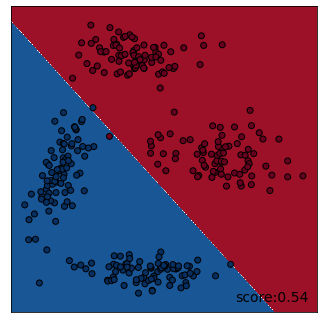

In [22]:
def plotDecisionBoundary(estimator, x_val, m, score=0.8, class_strategy='binary', fit_intercept=True, bias_value=1):
    #https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
    figure = plt.figure(figsize=(9, 9))
    i=1

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if fit_intercept:
        # do not take intercept data
        x_min, x_max = x_val[:, 1].min() - .5, x_val[:, 1].max() + .5
        y_min, y_max = x_val[:, 2].min() - .5, x_val[:, 2].max() + .5
    else:
        x_min, x_max = x_val[:, 0].min() - .5, x_val[:, 0].max() + .5
        y_min, y_max = x_val[:, 1].min() - .5, x_val[:, 1].max() + .5

    step_size = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

    x_bound = np.c_[xx.ravel(), yy.ravel()]
    
    if fit_intercept:
        x_bound = np.hstack((np.full((x_bound.shape[0], 1), bias_value), x_bound))
    
    if class_strategy=='binary':
        Z = np.array(estimator.predict(x_bound, h))
    elif class_strategy =='ovr':
        Z = np.array(estimator.predictMulti(x_bound, h))
    elif class_strategy =='maxent':
        Z = np.array(estimator.predictMaxent(x_bound, h))
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    ax=plt.subplot(2, 2, i)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu)

    # Plot also the training points
    if fit_intercept:
        ax.scatter(x_val[:, 1], x_val[:, 2], c=np.squeeze(y_train), edgecolors='k', cmap=plt.cm.RdBu)
    else:
        ax.scatter(x_val[:, 0], x_val[:, 1], c=np.squeeze(y_train), edgecolors='k', cmap=plt.cm.RdBu)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ax.text(xx.max() - .3, yy.min() + .3, ('score:%.2f' % score).lstrip('0'),
        size=14, horizontalalignment='right', color='black')

    plt.tight_layout()
    plt.show()
    
plotDecisionBoundary(gd, X_, m, class_strategy='binary', fit_intercept=False, score=(preds == y_test).mean())

***
### Model Interpretability

In [18]:
import statsmodels.api as sm

* All the other variables have their p-values smaller than 0.05, and are, therefore, significant.

In [19]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

model = sm.MNLogit(y_train, X_)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.042150
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  320
Model:                        MNLogit   Df Residuals:                      318
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Jul 2020   Pseudo R-squ.:                  0.9391
Time:                        15:44:28   Log-Likelihood:                -13.488
converged:                       True   LL-Null:                       -221.65
Covariance Type:            nonrobust   LLR p-value:                 1.539e-92
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.5313      0.538     -4.707      0.000      -3.585      -1.477
x2            -2.6942      0